### Permasalahan

> Churn adalah salah satu peristiwa atau perilaku pelanggan beralih dari produk setelah (dalam jangka waktu tertentu) berlangganan produk. Produk dapat berupa barang atau jasa, seperti jaringan internet, penyedia telekomunikasi, dan sejenisnya. Dalam hal ini produk yang dianalisa adalah perusahaan telekomunikasi. Skema churn dapat dijelaskan dalam beberapa tahap. Tahap pertama, tahap ketika pelanggan berlangganan produk. Tahap kedua, yaitu rutinitas, atau perilaku pelanggan atau umpan balik pelanggan terhadap produk yang digunakan selama periode tertentu. Setelah itu, pada tahap ketiga, ada dua jenis, retensi (berlangganan kembali) atau churn (beralih atau berhenti berlangganan). Setiap perusahaan pasti ingin meminimalkan churn dan memaksimalkan retensi. Salah satu solusi yang dapat digunakan adalah dengan menggunakan prediksi churn pelanggan. Dengan ini, perusahaan dapat mengetahui karakteristik yang cenderung beralih atau berhenti berlangganan.

### Deskripsi Data

1.   Gender: Jenis kelamin pelanggan (Male, Female)
2.   Partner: Status pernikahan pelanggan (yes, no)
3.   Tenure: Lama beralangganan (integer; bulan)
4.   PhoneService: Apakah pelanggan menggunakan telfon (yes, no)
5.   PaperlessBilling:  Apakah pelanggan menggunakan paperless billing (yes, no)
6.   MonthlyCharges: Biaya bulanan (numeric; usd)
7.   Churn: Apakah pelanggan berhenti berlangganan atau tidak (yes, no)

> Dalam kasus ini akan dilakukan prediksi Churn sebagai variabel respon.




## 1. Import Libraries and Data

IMPORT PACKAGES

In [ ]:
# Import Package
import os
import pandas as pd
import numpy as np

# Package untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Package untuk cleaning, modelling, dan evaluation model
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

IMPORT DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Narasio/TelcoChurn.csv"
df = pd.read_csv(path)
df

,gender,Partner,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn
0,Female,Yes,1,No,Yes,29.85,No
1,Male,No,34,Yes,No,56.95,No
2,Male,No,2,Yes,Yes,53.85,Yes
3,Male,No,45,No,No,42.30,No
4,Female,No,2,Yes,Yes,70.70,Yes
...,...,...,...,...,...,...,...
7038,Male,Yes,24,Yes,Yes,84.80,No
7039,Female,Yes,72,Yes,Yes,103.20,No
7040,Female,Yes,11,No,Yes,29.60,No
7041,Male,Yes,4,Yes,Yes,74.40,Yes


## 2. Exploratory Data Analysis (EDA)

In [ ]:
df.info()
print("-----------------------------------")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   Partner           7043 non-null   object 
 2   tenure            7043 non-null   int64  
 3   PhoneService      7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 385.3+ KB
-----------------------------------


,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


In [ ]:
#Cek missing data
df.isnull().sum()

gender              0
Partner             0
tenure              0
PhoneService        0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

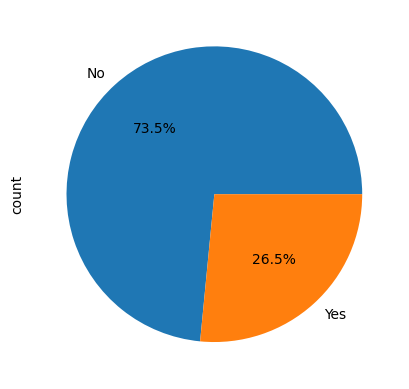

In [ ]:
#Distribusi pelanggan berhenti dan tidak
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

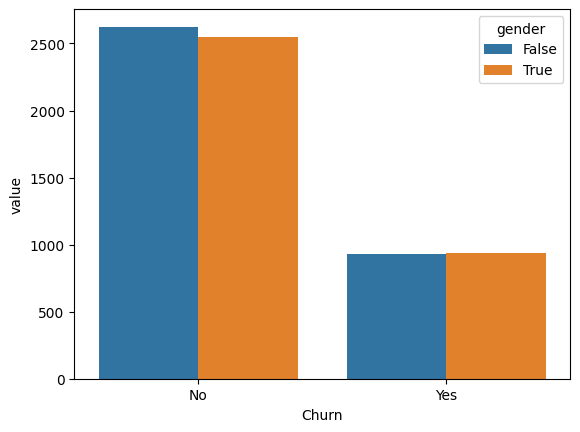

In [ ]:
#Perbandingan kelompok gender pada status berlangganan
churn_gender = pd.crosstab(df['Churn'], (df['gender']=="Female")) #Female = True

stacked = churn_gender.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked.Churn, y=stacked.value, hue=stacked.gender)
plt.show()

📊 Dari diagram di atas, diketahui bahwa **pelanggan dengan status berlangganan lebih banyak pada laki-laki** (False = laki-laki, True = perempuan), tapi tidak ada perbedaan yang terlalu signifikan antara keduanya. Sedangkan **pada status berhenti lebih banyak pada perempuan**, tapi juga **tidak berbeda secara signifikan** antara laki-laki dan perempuan.

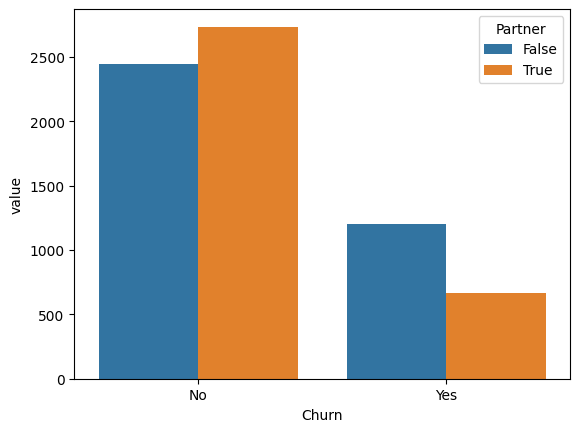

In [ ]:
#Perbandingan status pernikahan pada status berlangganan
churn_partner = pd.crosstab(df['Churn'], (df['Partner']=="Yes")) #Sudah menikah = True

stacked = churn_partner.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked.Churn, y=stacked.value, hue=stacked.Partner)
plt.show()

📊 Dari diagram, dapat disimpulkan bahwa **pelanggan dengan status berlangganan lebih banyak pada kelompok yang sudah menikah** (True = sudah menikah, False = belum menikah). Sedangkan kelompok **pelanggan dengan status berhenti lebih banyak diisi oleh pelanggan yang belum menikah**. Dapat diasumsikan bahwa status pernikahan/sudah menikah akan cenderung tidak berhenti berlangganan. Namun, perbedaan distribusi antara kedua kelompok juga tidak sangat jauh perbedaannya.

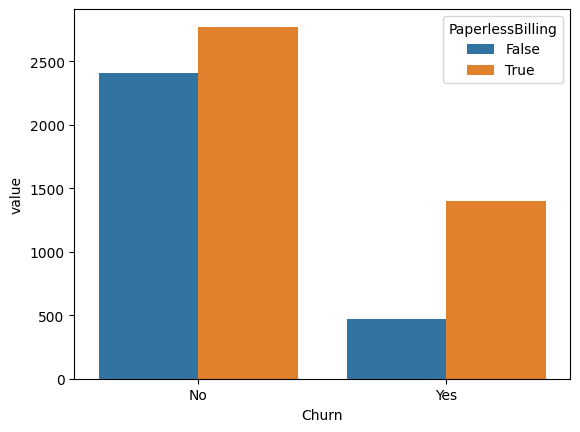

In [ ]:
#Perbandingan status paperless billing pada status berlangganan
churn_paperless = pd.crosstab(df['Churn'], (df['PaperlessBilling']=="Yes")) #Menggunakan paperless billing = True

stacked = churn_paperless.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked.Churn, y=stacked.value, hue=stacked.PaperlessBilling)
plt.show()

📊 Dari diagram di atas, didapatkan informasi bahwa **tidak terdapat perbedaan kecenderungan untuk penggunaan paperless billing dan tidak pada status berlangganan maupun berhenti berlangganan**. Baik berlangganan ataupun berhenti, sama-sama didominasi oleh kelompok dengan paperless billing. Namun, perbedaannya cukup jauh pada kelompok yang berhenti berlangganan. Oleh karena itu tidak dapat disimpulkan bahwa pelanggan yang berhenti berlangganan adalah dikarenakan oleh tidak digunakannya sistem paperless billing.

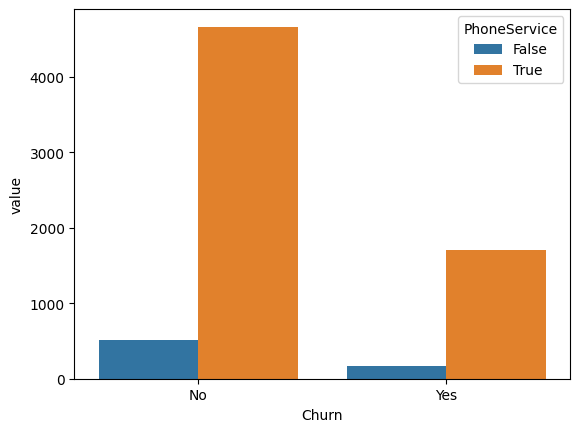

In [ ]:
#Perbandingan status penggunaan telepon pada status berlangganan
churn_phone = pd.crosstab(df['Churn'], (df['PhoneService']=="Yes")) #Menggunakan layanan telepon = True

stacked = churn_phone.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked.Churn, y=stacked.value, hue=stacked.PhoneService)
plt.show()

📊 Dari diagram di atas, terlihat juga bahwa **tidak terdapat perbedaan kecenderungan antara pengunaan layanan telepon dan tidak pada kedua status berlangganan**. Baik berlangganan ataupun sudah berhenti, sama-sama didominasi oleh kelompok yang menggunakan layanan telepon. Oleh karena itu, tidak dapat disimpulkan bahwa penggunaan telepon menyebabkan pelanggan berhenti berlangganan.

<Axes: xlabel='Churn', ylabel='tenure'>

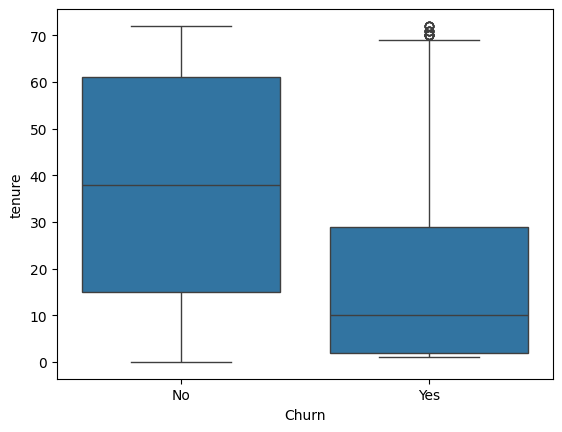

In [ ]:
#Perbandingan lama berlangganan pada status berlangganan
sns.boxplot(x="Churn", y="tenure", data=df)

📊 Dari boxplot di atas, terlihat bahwa pelanggan yang berhenti berlangganan didominasi oleh pelanggan dengan lama berlangganan yang lebih sebentar. **Dapat diasumsikan bahwa semakin lama pelanggan berlangganan, pelanggan akan cenderung masih tetap berlangganan.**

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

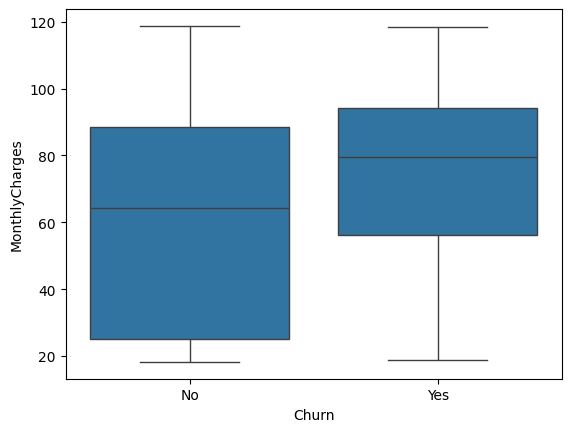

In [ ]:
#Perbandingan biaya bulanan pada status berlangganan
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)

📊 Dari boxplot di atas, terlihat bahwa pelanggan yang berhenti berlangganan memiliki biaya bulanan yang lebih mahal. **Dapat diasumsikan bahwa pelanggan dengan biaya bulanan yang lebih tinggi akan lebih cenderung untuk berhenti berlangganan.**

## 3 Preprocessing

Label Encoder

In [ ]:
kategori = ["gender", "Partner", "PhoneService",	"PaperlessBilling",	"Churn"]
df_cat = df[kategori]
df_cat.head()

,gender,Partner,PhoneService,PaperlessBilling,Churn
0,Female,Yes,No,Yes,No
1,Male,No,Yes,No,No
2,Male,No,Yes,Yes,Yes
3,Male,No,No,No,No
4,Female,No,Yes,Yes,Yes


In [ ]:
encoded_data = LabelEncoder()

for feature in kategori:
        if feature in df.columns.values:
            df[feature] = encoded_data.fit_transform(df[feature])

df.head()

,gender,Partner,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn
0,0,1,1,0,1,29.85,0
1,1,0,34,1,0,56.95,0
2,1,0,2,1,1,53.85,1
3,1,0,45,0,0,42.30,0
4,0,0,2,1,1,70.70,1


In [ ]:
#Scalling
transformation_svm = MinMaxScaler().fit(df[['tenure','MonthlyCharges']])
df[['tenure','MonthlyCharges']]=transformation_svm.transform(df[['tenure','MonthlyCharges']])

df.head()

,gender,Partner,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn
0,0,1,0.013889,0,1,0.115423,0
1,1,0,0.472222,1,0,0.385075,0
2,1,0,0.027778,1,1,0.354229,1
3,1,0,0.625000,0,0,0.239303,0
4,0,0,0.027778,1,1,0.521891,1


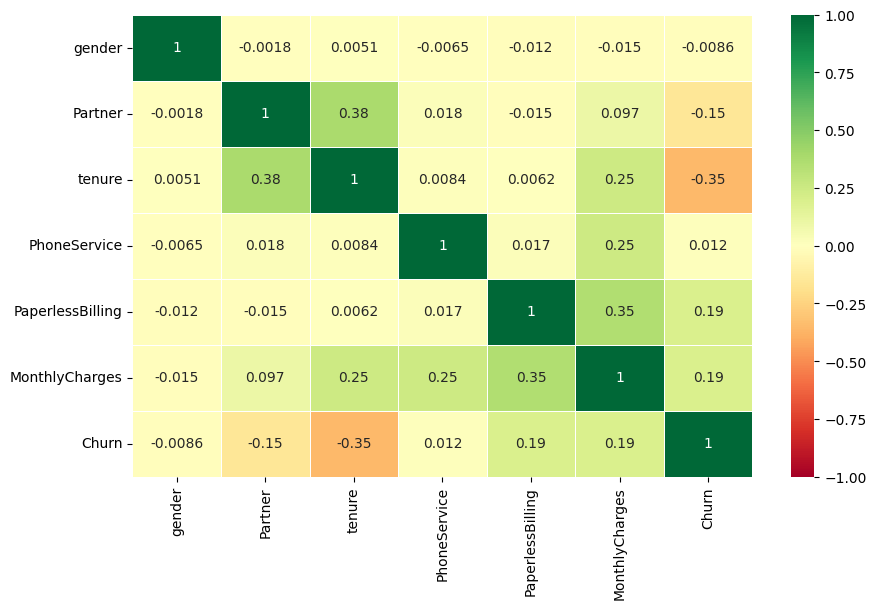

In [ ]:
# Cek korelasi, mengasumsikan bahwa data bertime interval-rasio
sns.heatmap(df.corr(),linewidths=.5,annot=True,cmap='RdYlGn', vmin=-1, vmax=1)
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

In [ ]:
#Urutan korelasi terendah ke tertinggi
korelasi = df.corr()["Churn"].sort_values()
korelasi

tenure             -0.352229
Partner            -0.150448
gender             -0.008612
PhoneService        0.011942
PaperlessBilling    0.191825
MonthlyCharges      0.193356
Churn               1.000000
Name: Churn, dtype: float64

📊 Tidak terdapat hubungan yang sangat kuat dari variabel-variabel lain dengan variabel Churn. Nilai terkuat ada pada hubungan Churn dengan variabel tenure. Begitu pula dengan antarvariabel independen lain, tidak ada hubungan yang sangat kuat. Nilai terbesar ada pada hubungan Partner dengan tenure.

## 5. Membangun Model Klasifikasi

MEMBAGI TRAIN TEST DATA

Menggunakan data testing berjumlah 30persen dari total data, dan data training berjumlah 70persen dari total data.

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Ukuran X Train : ", len(X_train))
print("Ukuran y Train : ", len(y_train))
print("Ukuran X Test : ", len(X_test))
print("Ukuran y Test : ", len(y_test))

Ukuran X Train :  4930
Ukuran y Train :  4930
Ukuran X Test :  2113
Ukuran y Test :  2113


### Stats Model (Logistic Regression)

In [ ]:
Input = sm.add_constant(X_train)

In [ ]:
model = sm.Logit(y_train, X_train, missing='drop')
result = model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.451123
         Iterations 7
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: Churn            Pseudo R-squared: 0.217      
Date:               2024-04-17 11:19 AIC:              4460.0722  
No. Observations:   4930             BIC:              4499.0908  
Df Model:           5                Log-Likelihood:   -2224.0    
Df Residuals:       4924             LL-Null:          -2838.9    
Converged:          1.0000           LLR p-value:      1.0834e-263
No. Iterations:     7.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender            -0.1413   0.0710  -1.9918 0.0464 -0.2804 -0.0023
Partner           -0.1549   0.0792  -1.9570 0.0503 -0

📊 Dengan iterasi 7x, didapatkan hasil uji Omnibusnya adalah kurang dari alpha sehingga dapat disimpulkan bahwa variabel berpengaruh signifikan secara serentak. Dari hasil pengujian hubungan variabel-variabel independen dengan Churn, didapatkan hasil bahwa semua berpengaruh secara signifikan (karena nilai p kurang dr alpha 0.05), kecuali untuk variabel gender dan partner.

In [ ]:
#Odds ratio
round(np.exp(result.params), 3)

gender               0.868
Partner              0.856
tenure               0.019
PhoneService         0.256
PaperlessBilling     1.496
MonthlyCharges      25.273
dtype: float64

📊 Dengan hasil odds ratio sebagai berikut, diketahui bahwa dengan peningkatan biaya bulanan, akan membuat pelanggan 25x lebih mungkin untuk berubah dari status berlangganan menjadi berhenti.

Prediksi Model

In [ ]:
prediction = result.predict(X_test)

In [ ]:
pred_results = pd.DataFrame(prediction, columns = ["logreg_pred"])
pred_results["prediksi"] = pred_results['logreg_pred'].apply(lambda x: 1 if x > 0.5 else 0)
pred_results['actual'] = y_test
pred_results

,logreg_pred,prediksi,actual
185,0.599358,1,1
2715,0.041259,0,0
3825,0.012605,0,0
1807,0.610897,1,1
132,0.015133,0,0
...,...,...,...
5522,0.658011,1,1
6377,0.741599,1,1
5500,0.026008,0,0
2392,0.530204,1,0


### Evaluation Model

In [ ]:
print('Test accuracy =  {:.3f}'.format(accuracy_score(pred_results['actual'], pred_results["prediksi"])))
print('Test precision =  {:.3f}'.format(precision_score(pred_results['actual'], pred_results["prediksi"], average='binary')))
print('Test recall =  {:.3f}'.format(recall_score(pred_results['actual'], pred_results["prediksi"], average='binary')))
print('Test f-score =  {:.3f}'.format(f1_score(pred_results['actual'], pred_results["prediksi"], average='binary')))

Test accuracy =  0.792
Test precision =  0.644
Test recall =  0.526
Test f-score =  0.579


📊 Perbandingan jumlah prediksi yang benar dengan keseluruhan hasil prediksi dapat dilihat pada nilai akurasi, yaitu sebesar 79,2%. Kemudian terdapat pula nilai presicion sebesar 64,4%, yaitu seberapa banyak nilai yang benar dibandingkan dengan semua yang diprediksi positif (dari istilah True Positive, False Positive, dll). Selain itu, juga terdapat nilai recall sebesar 52,6% dan f-score 57,9%. Nilai recall merupakan banyaknya prediksi positif yang secara aktual juga positif (True Positive) dari keseluruhan kelas positif.

### SKLEARN (Logistic Regression)

In [ ]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = LR.predict(X_test)
logreg_test = pd.merge(X_test, y_test, left_index=True, right_index=True, how='outer')
logreg_test['prediction'] = y_pred
logreg_test.head()

,gender,Partner,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,prediction
185,0,1,0.013889,0,1,0.065174,1,0
2715,1,0,0.569444,1,1,0.069652,0,0
3825,0,1,0.722222,1,0,0.010945,0,0
1807,0,0,0.013889,1,0,0.578109,1,1
132,1,0,0.930556,1,0,0.321393,0,0


In [ ]:
print('Accuracy of logistic regression classifier train data: {:.3f}'.format(LR.score(X_train, y_train)))
print('Accuracy of logistic regression classifier test data: {:.3f}'.format(LR.score(X_test, y_test)))

Accuracy of logistic regression classifier train data: 0.788
Accuracy of logistic regression classifier test data: 0.792


📊 Dengan Sklearn, tidak terdapat perbedaan akurasi yang signifikan dengan metode stats model.

## Klasifikasi dengan SVM

MEMBAGI TRAIN TEST DATA

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Ukuran X Train : ", len(X_train))
print("Ukuran y Train : ", len(y_train))
print("Ukuran X Test : ", len(X_test))
print("Ukuran y Test : ", len(y_test))

Ukuran X Train :  4930
Ukuran y Train :  4930
Ukuran X Test :  2113
Ukuran y Test :  2113


MEMBANGUN MODEL CLASSIFIER DENGAN SVC KERNEL RBF

In [ ]:
classifier = SVC(kernel = 'rbf', gamma= 0.2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
#Akurasi train data
X_pred = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_pred,y_train)
print('Accuracy on training data : ', training_data_accuracy)

Accuracy on training data :  0.7821501014198783


In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1442   97]
 [ 349  225]]


In [ ]:
#Akurasi test data
test_data_accuracy = accuracy_score(y_pred,y_test)
print('Accuracy on test data : ', test_data_accuracy)

Accuracy on test data :  0.7889256980596309


KERNEL LINIER

In [ ]:
classifier = SVC(kernel = 'linear', gamma= 0.2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

#Akurasi test data
test_data_accuracy = accuracy_score(y_pred,y_test)
print('Accuracy on test data : ', test_data_accuracy)

Accuracy on test data :  0.7936583057264552


📊 Nilai akurasi test dan train dari rbf dan kernel tidak jauh berbeda dengan nilai akurasi dari pemodelan stats model dan sklearn. Jika dibandingkan dengan rbf, nilai akurasi dari kernel linier lebih tinggi. Dari confusion matrix juga terlihat lumayan baik dengan didominasi oleh nilai true positive (1442).

MENDAPATKAN AUC SCORE

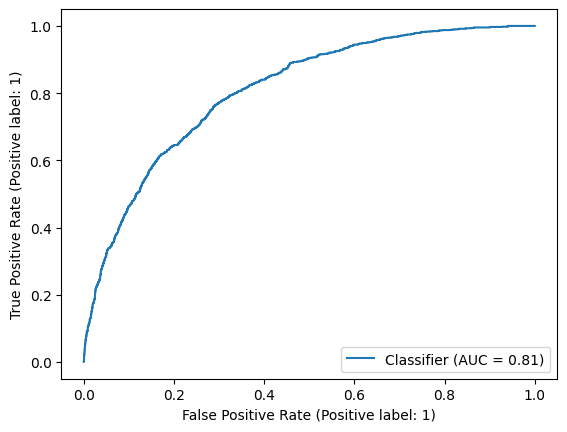

In [ ]:
from sklearn.metrics import RocCurveDisplay
y_score = classifier.decision_function(X_train)

RocCurveDisplay.from_predictions(y_train, y_score)

📊 Dari hasil di atas, didapatkan nilai AUC sebesar 81% yang dapat dikatakan baik tetapi belum sempurna.

# **Kesimpulan**
*   Peningkatan biaya bulanan membuat pelanggan 25x lebih mungkin untuk berubah dari status berlangganan menjadi berhenti.
*   Dilakukan perbandingan antara 3 model prediksi (stats model, sklearn, dan SVM) dan didapatkan rentang akurasi 78-80% yang tidak berbeda jauh antara ketiganya.

